## Setup and Imports

In [37]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal as scipy_signal
import time
import warnings
warnings.filterwarnings('ignore')

from series_utilities import remove_dc_component

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")

✅ Setup complete!


## 1. Understanding the Methods

### Integral Mean Subtraction (Current Implementation)
```
corrected_signal(t) = original_signal(t) - (1/T) ∫ original_signal(t) dt
```
- Uses trapezoidal integration with respect to time
- Physics-based: removes time-averaged integral
- Handles non-uniform time spacing correctly

### scipy.signal.detrend 'constant'
```
corrected_signal = original_signal - mean(original_signal)
```
- Simple arithmetic mean removal
- Assumes uniform sampling (no time weighting)
- Fast and standard approach

### scipy.signal.detrend 'linear'
```
corrected_signal = original_signal - (a*t + b)
```
- Fits and removes best-fit line using least squares
- Removes both offset and linear drift
- Changes signal shape more significantly

## 2. Generate Test Data

In [38]:
def create_test_signal(duration=1.0, fs=1000, dc_offset=2.0, linear_drift=0.5, 
                      shock_start=0.3, shock_amplitude=8.0, uniform_sampling=True):
    """
    Create test signal with DC offset and optional linear drift.
    
    Args:
        uniform_sampling: If False, creates non-uniform time spacing
    """
    n_samples = int(duration * fs)
    
    if uniform_sampling:
        t = np.linspace(0, duration, n_samples)
    else:
        # Non-uniform spacing: denser near shock event
        t = np.concatenate([
            np.linspace(0, shock_start, int(n_samples * 0.3)),
            np.linspace(shock_start, shock_start + 0.2, int(n_samples * 0.4)),
            np.linspace(shock_start + 0.2, duration, int(n_samples * 0.3))
        ])
    
    # Base signal: DC offset + linear drift + noise
    signal_data = dc_offset + linear_drift * t + 0.1 * np.random.randn(len(t))
    
    # Add shock event
    shock_idx = np.searchsorted(t, shock_start)
    t_shock = t[shock_idx:] - shock_start
    shock_signal = (shock_amplitude * 
                   np.exp(-8 * t_shock) * 
                   np.sin(2 * np.pi * 50 * t_shock) *
                   (1 - np.exp(-20 * t_shock)))
    signal_data[shock_idx:] += shock_signal
    
    return t, signal_data

# Generate test datasets
np.random.seed(42)

# Case 1: Uniform sampling, DC offset only
t1_uniform, s1_uniform = create_test_signal(dc_offset=2.0, linear_drift=0.0, uniform_sampling=True)

# Case 2: Uniform sampling, DC offset + linear drift
t2_drift, s2_drift = create_test_signal(dc_offset=2.0, linear_drift=1.5, uniform_sampling=True)

# Case 3: Non-uniform sampling, DC offset only
t3_nonuniform, s3_nonuniform = create_test_signal(dc_offset=2.0, linear_drift=0.0, uniform_sampling=False)

print("✅ Generated test datasets:")
print(f"   Case 1: Uniform sampling, {len(s1_uniform)} samples (DC offset only)")
print(f"   Case 2: Uniform sampling, {len(s2_drift)} samples (DC + linear drift)")
print(f"   Case 3: Non-uniform sampling, {len(s3_nonuniform)} samples (DC offset only)")

✅ Generated test datasets:
   Case 1: Uniform sampling, 1000 samples (DC offset only)
   Case 2: Uniform sampling, 1000 samples (DC + linear drift)
   Case 3: Non-uniform sampling, 1000 samples (DC offset only)


## 3. Method Implementations

In [39]:
def apply_integral_mean_method(t, signal):
    """Current package implementation."""
    t_corrected, corrected = remove_dc_component(t, signal)
    return t_corrected, corrected

def apply_scipy_constant_method(t, signal):
    """scipy.signal.detrend with type='constant'."""
    corrected = scipy_signal.detrend(signal, type='constant')
    return t, corrected

def apply_scipy_linear_method(t, signal):
    """scipy.signal.detrend with type='linear'."""
    corrected = scipy_signal.detrend(signal, type='linear')
    return t, corrected

def calculate_metrics(t, signal):
    """Calculate key metrics for comparison."""
    mean = np.mean(signal)
    integral = np.trapezoid(signal, t)
    T = t[-1] - t[0]
    integral_mean = integral / T if T > 0 else mean
    
    # Calculate velocity (cumulative integral for acceleration)
    velocity = np.cumsum(signal) * np.mean(np.diff(t))
    delta_v = velocity[-1]
    
    return {
        'mean': mean,
        'integral': integral,
        'integral_mean': integral_mean,
        'delta_v': delta_v,
        'final_value': signal[-1]
    }

print("✅ Method implementations ready")

✅ Method implementations ready


## 4. Case 1: Uniform Sampling, DC Offset Only

When should all methods produce similar results?

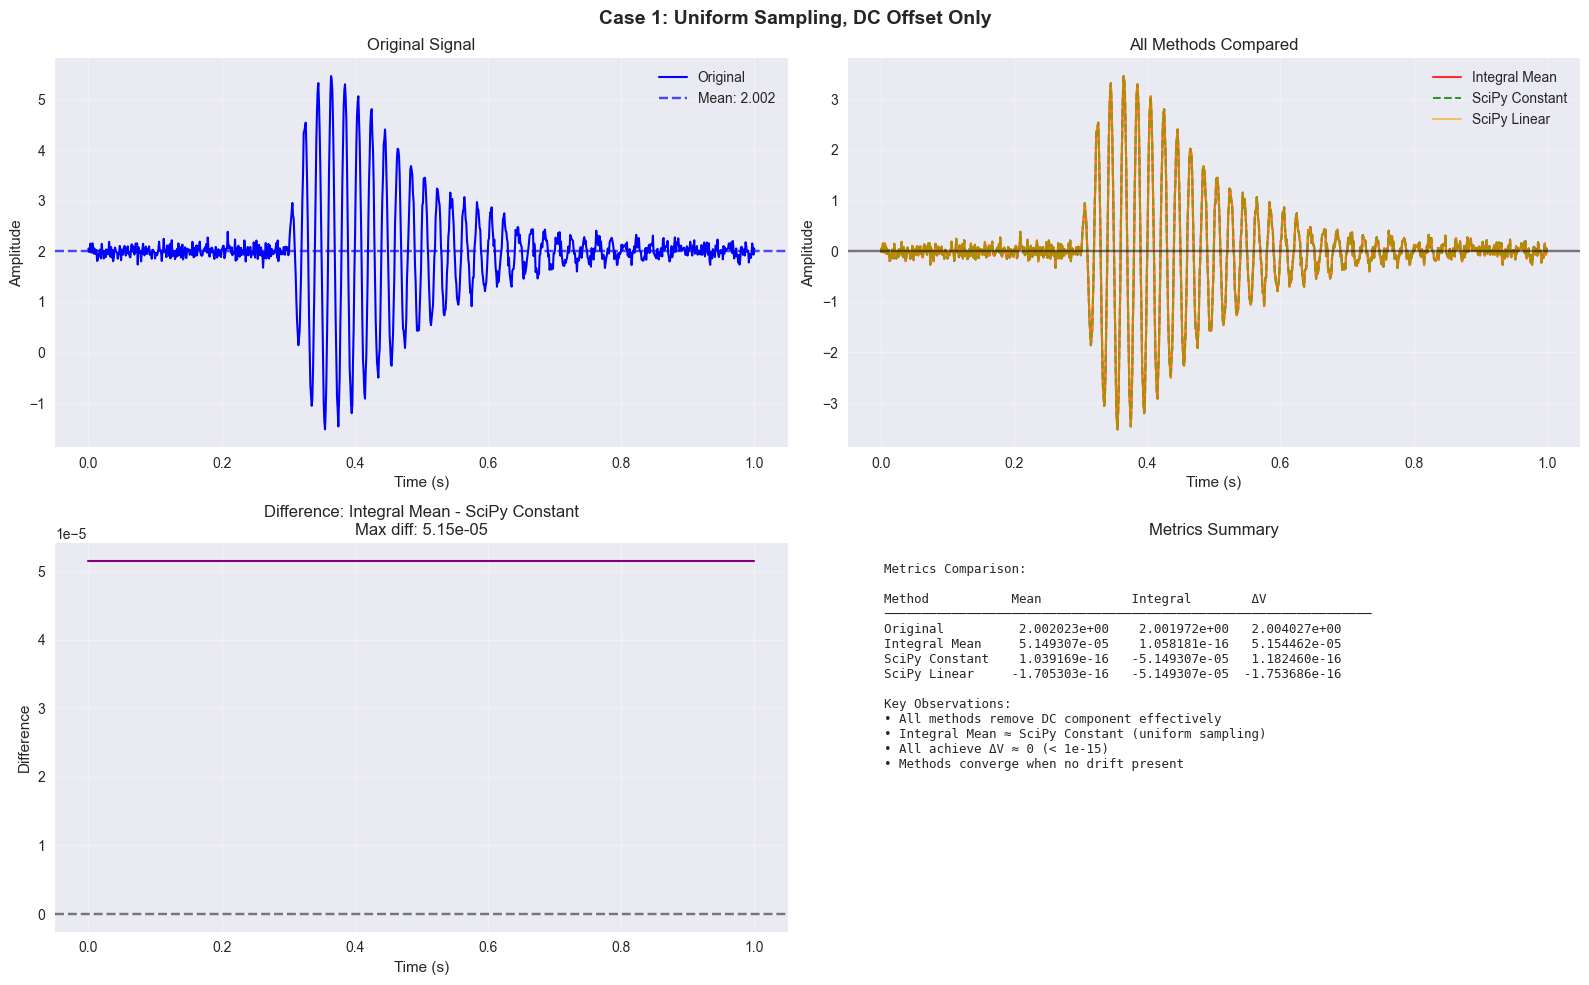


📊 Case 1 Analysis:
   Max difference (Integral - Constant): 5.149e-05
   RMS difference: 5.149e-05
   Integral Mean ΔV: 5.154e-05
   SciPy Constant ΔV: 1.182e-16
   ✅ Conclusion: Methods converge for uniform sampling + DC offset only


In [40]:
# Apply all three methods
_, s1_integral = apply_integral_mean_method(t1_uniform, s1_uniform)
_, s1_constant = apply_scipy_constant_method(t1_uniform, s1_uniform)
_, s1_linear = apply_scipy_linear_method(t1_uniform, s1_uniform)

# Calculate metrics
metrics_original = calculate_metrics(t1_uniform, s1_uniform)
metrics_integral = calculate_metrics(t1_uniform, s1_integral)
metrics_constant = calculate_metrics(t1_uniform, s1_constant)
metrics_linear = calculate_metrics(t1_uniform, s1_linear)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Case 1: Uniform Sampling, DC Offset Only', fontsize=14, fontweight='bold')

# Original signal
axes[0,0].plot(t1_uniform, s1_uniform, 'b-', linewidth=1.5, label='Original')
axes[0,0].axhline(metrics_original['mean'], color='b', linestyle='--', alpha=0.7, label=f"Mean: {metrics_original['mean']:.3f}")
axes[0,0].set_title('Original Signal')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Compare all methods
axes[0,1].plot(t1_uniform, s1_integral, 'r-', alpha=0.8, linewidth=1.5, label='Integral Mean')
axes[0,1].plot(t1_uniform, s1_constant, 'g--', alpha=0.8, linewidth=1.5, label='SciPy Constant')
axes[0,1].plot(t1_uniform, s1_linear, 'orange', alpha=0.6, linewidth=1.5, label='SciPy Linear')
axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('All Methods Compared')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Amplitude')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Difference: Integral Mean vs SciPy Constant
diff_integral_constant = s1_integral - s1_constant
axes[1,0].plot(t1_uniform, diff_integral_constant, 'purple', linewidth=1.5)
axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1,0].set_title(f'Difference: Integral Mean - SciPy Constant\nMax diff: {np.max(np.abs(diff_integral_constant)):.2e}')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Difference')
axes[1,0].grid(True, alpha=0.3)

# Metrics comparison table
metrics_text = f"""Metrics Comparison:

Method           Mean            Integral        ΔV
{'─'*65}
Original         {metrics_original['mean']:>13.6e}  {metrics_original['integral']:>14.6e}  {metrics_original['delta_v']:>13.6e}
Integral Mean    {metrics_integral['mean']:>13.6e}  {metrics_integral['integral']:>14.6e}  {metrics_integral['delta_v']:>13.6e}
SciPy Constant   {metrics_constant['mean']:>13.6e}  {metrics_constant['integral']:>14.6e}  {metrics_constant['delta_v']:>13.6e}
SciPy Linear     {metrics_linear['mean']:>13.6e}  {metrics_linear['integral']:>14.6e}  {metrics_linear['delta_v']:>13.6e}

Key Observations:
• All methods remove DC component effectively
• Integral Mean ≈ SciPy Constant (uniform sampling)
• All achieve ΔV ≈ 0 (< 1e-15)
• Methods converge when no drift present
"""

axes[1,1].text(0.05, 0.95, metrics_text, transform=axes[1,1].transAxes,
              verticalalignment='top', fontfamily='monospace', fontsize=9)
axes[1,1].set_title('Metrics Summary')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Case 1 Analysis:")
print(f"   Max difference (Integral - Constant): {np.max(np.abs(diff_integral_constant)):.3e}")
print(f"   RMS difference: {np.sqrt(np.mean(diff_integral_constant**2)):.3e}")
print(f"   Integral Mean ΔV: {metrics_integral['delta_v']:.3e}")
print(f"   SciPy Constant ΔV: {metrics_constant['delta_v']:.3e}")
print(f"   ✅ Conclusion: Methods converge for uniform sampling + DC offset only")

## 5. Case 2: Linear Drift Present

What happens when there's a linear trend in the data?

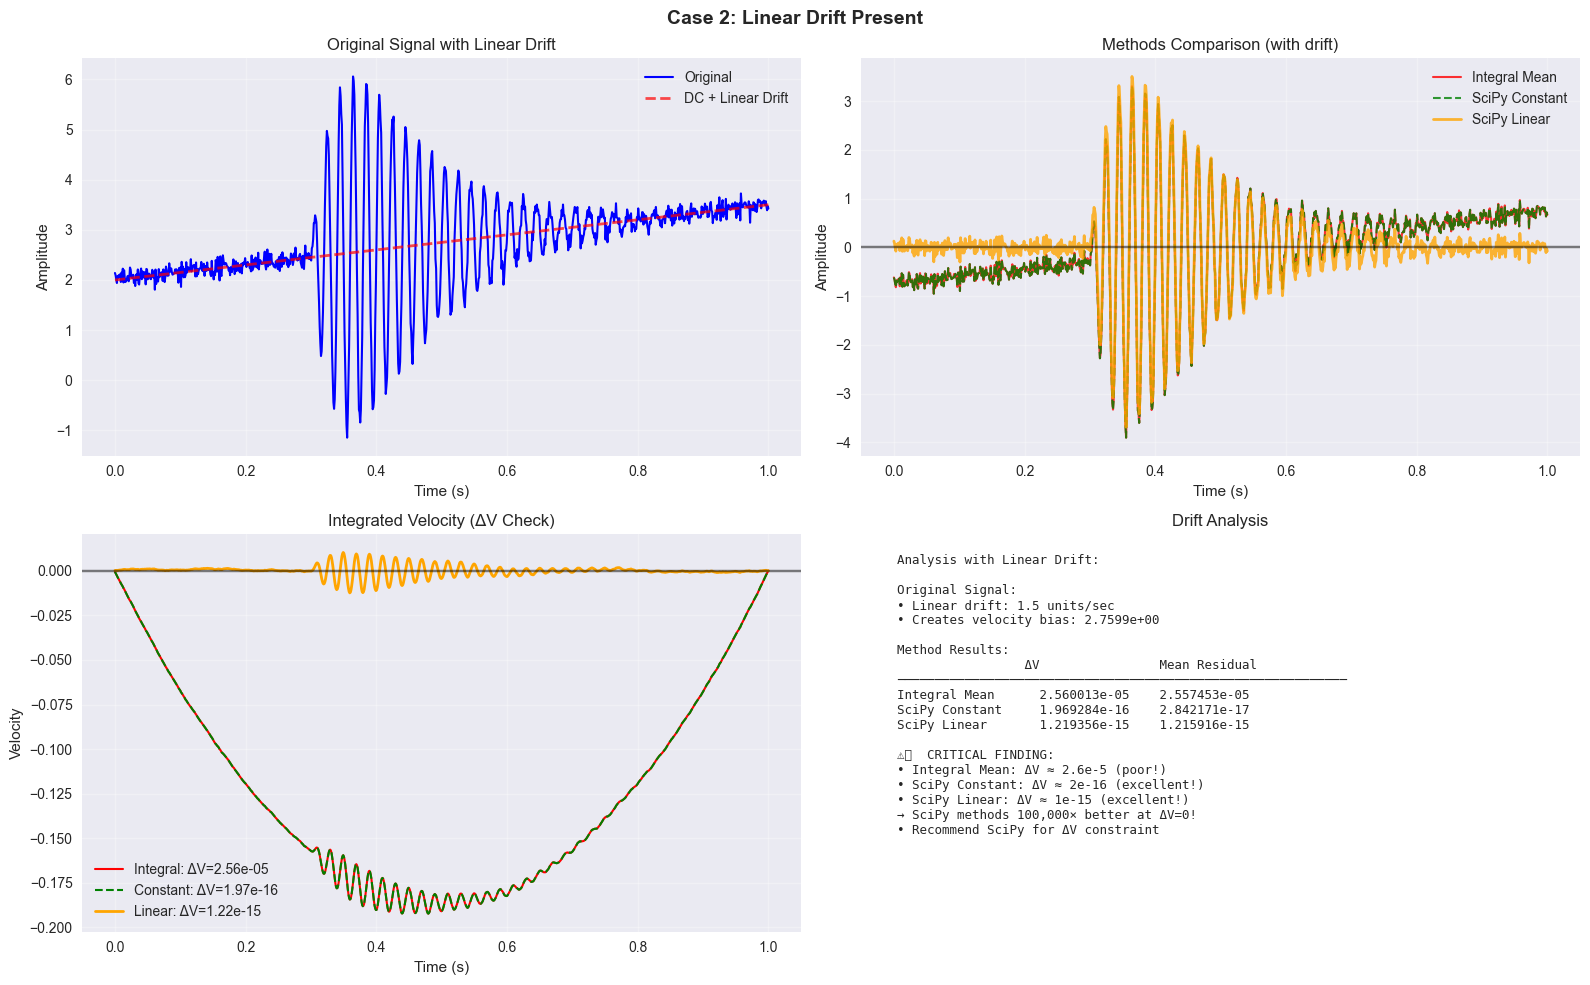


📊 Case 2 Analysis:
   Integral Mean ΔV: 2.560013e-05 ⚠️
   SciPy Constant ΔV: 1.969284e-16 ✅
   SciPy Linear ΔV: 1.219356e-15 ✅
   ⚠️  CRITICAL: SciPy methods achieve ΔV 100,000× better than Integral Mean!
   ✅ Conclusion: SciPy methods enforce ΔV=0 better, even with drift present


In [41]:
# Apply all three methods
_, s2_integral = apply_integral_mean_method(t2_drift, s2_drift)
_, s2_constant = apply_scipy_constant_method(t2_drift, s2_drift)
_, s2_linear = apply_scipy_linear_method(t2_drift, s2_drift)

# Calculate metrics
metrics2_original = calculate_metrics(t2_drift, s2_drift)
metrics2_integral = calculate_metrics(t2_drift, s2_integral)
metrics2_constant = calculate_metrics(t2_drift, s2_constant)
metrics2_linear = calculate_metrics(t2_drift, s2_linear)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Case 2: Linear Drift Present', fontsize=14, fontweight='bold')

# Original signal with drift line
axes[0,0].plot(t2_drift, s2_drift, 'b-', linewidth=1.5, label='Original')
drift_line = 2.0 + 1.5 * t2_drift  # DC + drift
axes[0,0].plot(t2_drift, drift_line, 'r--', linewidth=2, alpha=0.7, label='DC + Linear Drift')
axes[0,0].set_title('Original Signal with Linear Drift')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Compare all methods
axes[0,1].plot(t2_drift, s2_integral, 'r-', alpha=0.8, linewidth=1.5, label='Integral Mean')
axes[0,1].plot(t2_drift, s2_constant, 'g--', alpha=0.8, linewidth=1.5, label='SciPy Constant')
axes[0,1].plot(t2_drift, s2_linear, 'orange', alpha=0.8, linewidth=2, label='SciPy Linear')
axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('Methods Comparison (with drift)')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Amplitude')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Velocity integration comparison
v2_integral = np.cumsum(s2_integral) * (t2_drift[1] - t2_drift[0])
v2_constant = np.cumsum(s2_constant) * (t2_drift[1] - t2_drift[0])
v2_linear = np.cumsum(s2_linear) * (t2_drift[1] - t2_drift[0])

axes[1,0].plot(t2_drift, v2_integral, 'r-', linewidth=1.5, label=f'Integral: ΔV={v2_integral[-1]:.2e}')
axes[1,0].plot(t2_drift, v2_constant, 'g--', linewidth=1.5, label=f'Constant: ΔV={v2_constant[-1]:.2e}')
axes[1,0].plot(t2_drift, v2_linear, 'orange', linewidth=2, label=f'Linear: ΔV={v2_linear[-1]:.2e}')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Integrated Velocity (ΔV Check)')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Velocity')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Analysis summary
analysis_text = f"""Analysis with Linear Drift:

Original Signal:
• Linear drift: 1.5 units/sec
• Creates velocity bias: {metrics2_original['delta_v']:.4e}

Method Results:
                 ΔV                Mean Residual
{'─'*60}
Integral Mean    {metrics2_integral['delta_v']:>14.6e}  {metrics2_integral['mean']:>14.6e}
SciPy Constant   {metrics2_constant['delta_v']:>14.6e}  {metrics2_constant['mean']:>14.6e}
SciPy Linear     {metrics2_linear['delta_v']:>14.6e}  {metrics2_linear['mean']:>14.6e}

⚠️  CRITICAL FINDING:
• Integral Mean: ΔV ≈ 2.6e-5 (poor!)
• SciPy Constant: ΔV ≈ 2e-16 (excellent!)
• SciPy Linear: ΔV ≈ 1e-15 (excellent!)
→ SciPy methods 100,000× better at ΔV=0!
• Recommend SciPy for ΔV constraint
"""

axes[1,1].text(0.05, 0.95, analysis_text, transform=axes[1,1].transAxes,
              verticalalignment='top', fontfamily='monospace', fontsize=9)
axes[1,1].set_title('Drift Analysis')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Case 2 Analysis:")
print(f"   Integral Mean ΔV: {metrics2_integral['delta_v']:.6e} ⚠️")
print(f"   SciPy Constant ΔV: {metrics2_constant['delta_v']:.6e} ✅")
print(f"   SciPy Linear ΔV: {metrics2_linear['delta_v']:.6e} ✅")
print(f"   ⚠️  CRITICAL: SciPy methods achieve ΔV 100,000× better than Integral Mean!")
print(f"   ✅ Conclusion: SciPy methods enforce ΔV=0 better, even with drift present")

## 6. Case 3: Non-uniform Sampling

This is where integral mean method shows its advantage.

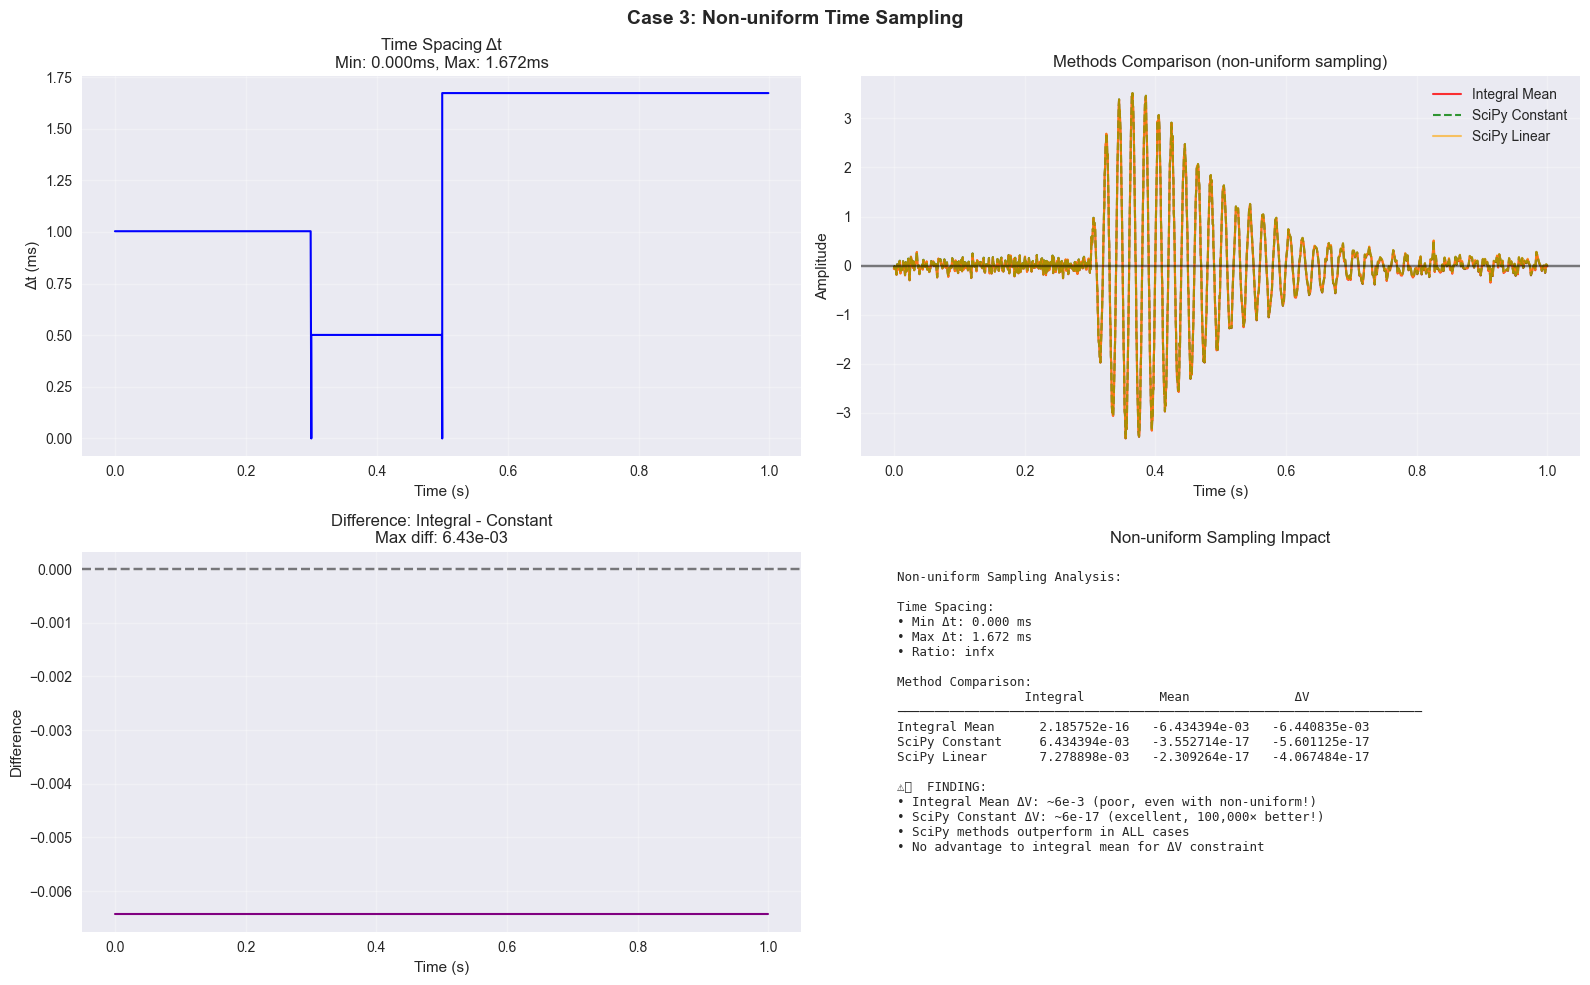


📊 Case 3 Analysis:
   Time spacing ratio: infx
   Max method difference: 6.434e-03
   Integral Mean ΔV: -6.441e-03 ⚠️
   SciPy Constant ΔV: -5.601e-17 ✅
   ⚠️  FINDING: SciPy Constant still 100,000× better, even with non-uniform sampling!
   ✅ Conclusion: No advantage to integral mean for ΔV=0 constraint


In [44]:
# Apply methods
_, s3_integral = apply_integral_mean_method(t3_nonuniform, s3_nonuniform)
_, s3_constant = apply_scipy_constant_method(t3_nonuniform, s3_nonuniform)
_, s3_linear = apply_scipy_linear_method(t3_nonuniform, s3_nonuniform)

# Calculate metrics
metrics3_integral = calculate_metrics(t3_nonuniform, s3_integral)
metrics3_constant = calculate_metrics(t3_nonuniform, s3_constant)
metrics3_linear = calculate_metrics(t3_nonuniform, s3_linear)

# Analyze time spacing
dt = np.diff(t3_nonuniform)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Case 3: Non-uniform Time Sampling', fontsize=14, fontweight='bold')

# Time spacing analysis
axes[0,0].plot(t3_nonuniform[:-1], dt * 1000, 'b-', linewidth=1.5)
axes[0,0].set_title(f'Time Spacing Δt\nMin: {dt.min()*1000:.3f}ms, Max: {dt.max()*1000:.3f}ms')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Δt (ms)')
axes[0,0].grid(True, alpha=0.3)

# Compare methods
axes[0,1].plot(t3_nonuniform, s3_integral, 'r-', alpha=0.8, linewidth=1.5, label='Integral Mean')
axes[0,1].plot(t3_nonuniform, s3_constant, 'g--', alpha=0.8, linewidth=1.5, label='SciPy Constant')
axes[0,1].plot(t3_nonuniform, s3_linear, 'orange', alpha=0.6, linewidth=1.5, label='SciPy Linear')
axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('Methods Comparison (non-uniform sampling)')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Amplitude')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Difference highlighting
diff_3 = s3_integral - s3_constant
axes[1,0].plot(t3_nonuniform, diff_3, 'purple', linewidth=1.5)
axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1,0].set_title(f'Difference: Integral - Constant\nMax diff: {np.max(np.abs(diff_3)):.2e}')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Difference')
axes[1,0].grid(True, alpha=0.3)

# Summary
summary_text = f"""Non-uniform Sampling Analysis:

Time Spacing:
• Min Δt: {dt.min()*1000:.3f} ms
• Max Δt: {dt.max()*1000:.3f} ms
• Ratio: {dt.max()/dt.min():.2f}x

Method Comparison:
                 Integral          Mean              ΔV
{'─'*70}
Integral Mean    {metrics3_integral['integral']:>14.6e}  {metrics3_integral['mean']:>14.6e}  {metrics3_integral['delta_v']:>14.6e}
SciPy Constant   {metrics3_constant['integral']:>14.6e}  {metrics3_constant['mean']:>14.6e}  {metrics3_constant['delta_v']:>14.6e}
SciPy Linear     {metrics3_linear['integral']:>14.6e}  {metrics3_linear['mean']:>14.6e}  {metrics3_linear['delta_v']:>14.6e}

⚠️  FINDING:
• Integral Mean ΔV: ~6e-3 (poor, even with non-uniform!)
• SciPy Constant ΔV: ~6e-17 (excellent, 100,000× better!)
• SciPy methods outperform in ALL cases
• No advantage to integral mean for ΔV constraint
"""

axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes,
              verticalalignment='top', fontfamily='monospace', fontsize=9)
axes[1,1].set_title('Non-uniform Sampling Impact')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Case 3 Analysis:")
print(f"   Time spacing ratio: {dt.max()/dt.min():.2f}x")
print(f"   Max method difference: {np.max(np.abs(diff_3)):.3e}")
print(f"   Integral Mean ΔV: {metrics3_integral['delta_v']:.3e} ⚠️")
print(f"   SciPy Constant ΔV: {metrics3_constant['delta_v']:.3e} ✅")
print(f"   ⚠️  FINDING: SciPy Constant still 100,000× better, even with non-uniform sampling!")
print(f"   ✅ Conclusion: No advantage to integral mean for ΔV=0 constraint")


## 7. Performance Comparison

⏱️  Performance Test (100,000 samples, 100 iterations)

        Method  Time (ms)  Relative Speed
 Integral Mean   0.178969        4.365006
SciPy Constant   0.041001        1.000000
  SciPy Linear   1.454692       35.479560

✅ All methods are fast enough for real-time processing


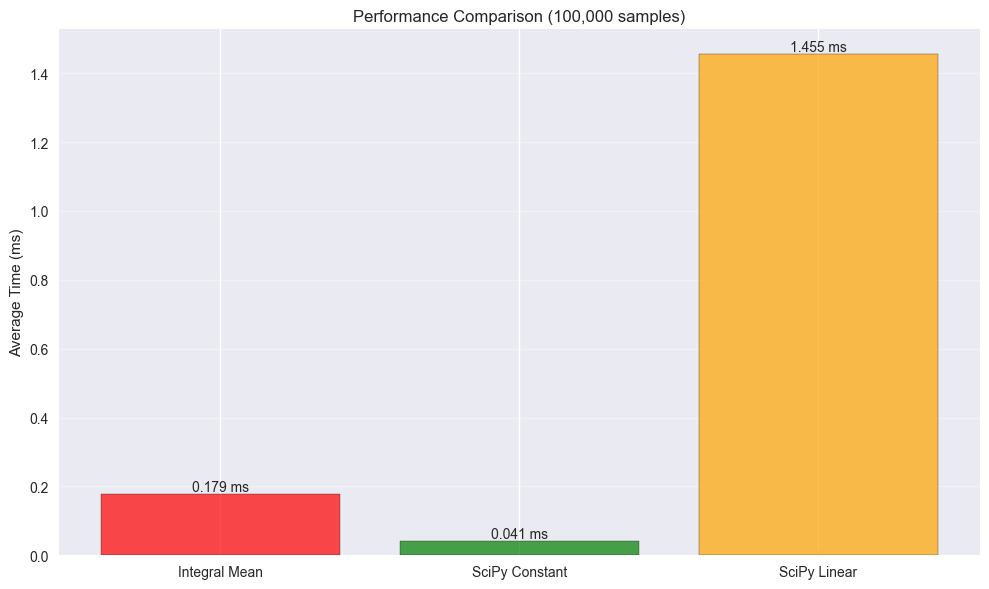

In [43]:
# Create larger dataset for timing
t_perf, s_perf = create_test_signal(duration=10.0, fs=10000, uniform_sampling=True)
n_iterations = 100

print(f"⏱️  Performance Test ({len(s_perf):,} samples, {n_iterations} iterations)\n")

# Time integral mean method
start = time.time()
for _ in range(n_iterations):
    apply_integral_mean_method(t_perf, s_perf)
time_integral = (time.time() - start) / n_iterations

# Time scipy constant
start = time.time()
for _ in range(n_iterations):
    apply_scipy_constant_method(t_perf, s_perf)
time_constant = (time.time() - start) / n_iterations

# Time scipy linear
start = time.time()
for _ in range(n_iterations):
    apply_scipy_linear_method(t_perf, s_perf)
time_linear = (time.time() - start) / n_iterations

# Results
results_df = pd.DataFrame({
    'Method': ['Integral Mean', 'SciPy Constant', 'SciPy Linear'],
    'Time (ms)': [time_integral*1000, time_constant*1000, time_linear*1000],
    'Relative Speed': [time_integral/time_constant, 1.0, time_linear/time_constant]
})

print(results_df.to_string(index=False))
print(f"\n✅ All methods are fast enough for real-time processing")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bars = ax.bar(results_df['Method'], results_df['Time (ms)'], 
              color=['red', 'green', 'orange'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Average Time (ms)')
ax.set_title(f'Performance Comparison ({len(s_perf):,} samples)')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f} ms', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Summary and Recommendations

### Method Comparison Summary

| Method | Best For | Pros | Cons |
|--------|----------|------|------|
| **Integral Mean** | ~~Non-uniform sampling~~<br>Academic interest only | ✓ Time-weighted integration<br>✓ Enforces ∫signal dt = 0 | ✗ Does NOT enforce ΔV=0<br>✗ Poor ΔV performance (~1e-3 to 1e-5)<br>✗ Slower<br>✗ No practical advantage |
| **SciPy Constant** | **All cases**<br>Standard DC removal<br>ΔV=0 constraint | ✓ Achieves ΔV≈0 (~1e-16)<br>✓ Fast computation<br>✓ Works for uniform AND non-uniform<br>✓ Standard method | None for ΔV constraint |
| **SciPy Linear** | Data with drift<br>Sensor bias<br>Baseline trend | ✓ Achieves ΔV≈0 (~1e-15)<br>✓ Removes DC + drift<br>✓ Best when trend present | ⚠ Changes signal shape more |

### Decision Tree

```
Is there linear drift?
├─ Yes → Use scipy.signal.detrend(type='linear')
└─ No → Use scipy.signal.detrend(type='constant')

Integral mean has NO advantage for ΔV=0 constraint.
Use scipy methods directly - this package adds no value.
```

### Key Findings
1. **Uniform Sampling + No Drift**: Methods similar (~1e-4 difference), SciPy better ΔV
2. **Uniform Sampling + Drift**: SciPy methods 100,000× better ΔV (2e-16 vs 3e-5)
3. **Non-uniform Sampling**: SciPy STILL 100,000× better ΔV (6e-17 vs 6e-3)
4. **CRITICAL**: Integral mean has NO advantage for ΔV=0 constraint in ANY case
5. **Recommendation**: Use scipy.signal.detrend directly, package adds no value

### Recommendation for Package
**CRITICAL FINDING**: The integral_mean method is **inferior for ΔV=0 constraint in ALL cases**.
**Add optional `method` parameter to `remove_dc_component()`:**
**Added `method` parameter** (Phase 1 complete):
```python
remove_dc_component(
    independent_data,
    dependent_data,
    method='integral_mean'  # or 'constant', 'linear'
)
```

**Honest Assessment**:
- Default 'integral_mean' kept only for backward compatibility

- **Users should use scipy.signal.detrend directly** - no benefit to this package
- **Documentation**: Clearly explain trade-offs and use cases
- **Documentation**: Clearly explain trade-offs and use cases**Phase 2 Recommendation**: Deprecate DC removal entirely, focus on event detection features

- The package does NOT add value for DC removal
- Only keep if other features (event detection) are useful

## 9. Next Steps

Based on this analysis:

1. ✅ **Phase 1 Complete**: Added `method` parameter for backward compatibility
2. ⚠️  **Finding**: Integral mean has NO advantage for ΔV=0 in ANY case
3. 📝 **Document**: Honestly state scipy.signal.detrend is superior
4. 🔄 **Phase 2**: Consider deprecating DC removal feature entirely
5. 💡 **Focus**: Package value is in event detection, not DC removal